# Discrete Time Sensor Fusion
RMM, 24 Feb 2022

In this example we work through estimation of the state of a car changing lanes with two different sensors available: one with good longitudinal accuracy and the other with good lateral accuracy.

All calculations are done in discrete time, using both a Kalman filter formulation and predictor-corrector form.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import control as ct
import control.optimal as opt
import control.flatsys as fs

# Define line styles
ebarstyle = {'elinewidth': 0.5, 'capsize': 2}
xdstyle = {'color': 'k', 'linestyle': '--', 'linewidth': 0.5, 
           'marker': '+', 'markersize': 4}

## System definition

We consider a bicycle model for an automobile:

<img src="../examples/vehicle-steering.png" width="400"/>

### Continuous time model
The dynamics are given by

$$
  \begin{aligned}
    \dot x &= \cos\theta \, v, \qquad
    \dot y &= \sin\theta \, v, \qquad
    \dot \theta &= \frac{v}{l} \tan\phi,
  \end{aligned}
$$

where $(x, y, \theta)$ are the position and orientation of the vehicle, $v$ is the forward velocity, $\phi$ is the steering wheel angle, and $l$ is the wheelbase.

These dynamics are included in the file `vehicle.py`:

In [2]:
# Vehicle steering dynamics
#
# System state: x, y, theta
# System input: v, phi
# System output: x, y
# System parameters: wheelbase, maxsteer
#
from vehicle import vehicle, plot_lanechange
print(vehicle)

<FlatSystem>: vehicle
Inputs (2): ['v', 'delta']
Outputs (3): ['x', 'y', 'theta']
States (3): ['x', 'y', 'theta']

Update: <function _vehicle_update at 0x140a4a2a0>
Output: <function _vehicle_output at 0x140a4a340>

Forward: <function _vehicle_flat_forward at 0x140a4a160>
Reverse: <function _vehicle_flat_reverse at 0x140a4a200>


This system is differentially flat and so we can define a trajectory for the system using the `flatsys` module.  We generate a motion that corresponds to changing lanes on a road:

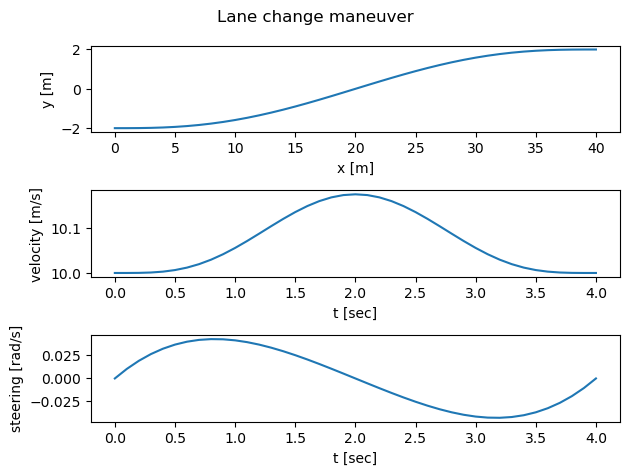

In [3]:
# Generate a trajectory for the vehicle
# Define the endpoints of the trajectory
x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [40., 2., 0.]; uf = [10., 0.]
Tf = 4

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle, Tf, x0, u0, xf, uf, basis=fs.PolyFamily(6))

# Create the desired trajectory between the initial and final condition
Ts = 0.1
timepts = np.arange(0, Tf + Ts, Ts)
xd, ud = traj.eval(timepts)

plot_lanechange(timepts, xd, ud)

### Discrete time system model

For the model that we use for the Kalman filter, we take a simple discretization using the approximation that $\dot x = (x[k+1] - x[k])/T_s$ where $T_s$ is the sampling time.

In [4]:
#
# Create a discrete-time, linear model
#

# Linearize about the starting point
veh_lin = ct.linearize(vehicle, x0, u0)

# Create a discrete-time model by hand
veh_lin_dt = ct.sample_system(veh_lin, Ts)

# Update the model to have full-state output
# veh_lin_dt = ct.ss(
#     veh_lin_dt.A, veh_lin_dt.B, np.eye(veh_lin_dt.nstates), 0, dt=veh_lin_dt.dt,
#     name="vehicle-lin-dt")
print(veh_lin_dt)

<StateSpace>: sys[0]$sampled
Inputs (2): ['u[0]', 'u[1]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']
dt = 0.1

A = [[ 1.0000000e+00  0.0000000e+00 -5.0004445e-07]
     [ 0.0000000e+00  1.0000000e+00  1.0000000e+00]
     [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]

B = [[ 9.99999999e-02 -8.33407417e-08]
     [ 0.00000000e+00  1.66666667e-01]
     [ 0.00000000e+00  3.33333333e-01]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]


### Sensor model

We assume that we have two sensors: one with good longitudinal accuracy and the other with good lateral accuracy.  For each sensor we define the map from the state space to the sensor outputs, the covariance matrix for the measurements, and a white noise signal (now in discrete time).

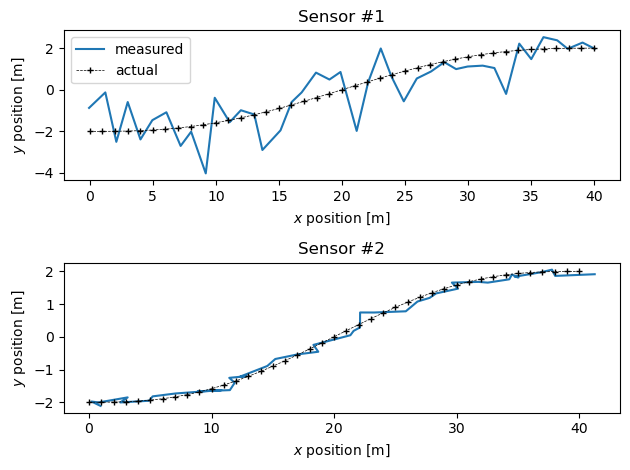

In [5]:
# Sensor #1: longitudinal
C_lon = np.eye(2, veh_lin_dt.nstates)
Rw_lon = np.diag([0.1 ** 2, 1 ** 2])
W_lon = ct.white_noise(timepts, Rw_lon, dt=Ts)

# Sensor #2: lateral
C_lat = np.eye(2, veh_lin_dt.nstates)
Rw_lat = np.diag([1 ** 2, 0.1 ** 2])
W_lat = ct.white_noise(timepts, Rw_lat, dt=Ts)

# Plot the noisy signals
plt.subplot(2, 1, 1)
Y = xd[0:2] + W_lon
plt.plot(Y[0], Y[1], label="measured")
plt.plot(xd[0], xd[1], **xdstyle, label="actual")
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #1")
plt.legend()
               
plt.subplot(2, 1, 2)
Y = xd[0:2] + W_lat
plt.plot(Y[0], Y[1])
plt.plot(xd[0], xd[1], **xdstyle)
plt.xlabel("$x$ position [m]")
plt.ylabel("$y$ position [m]")
plt.title("Sensor #2")
plt.tight_layout()

## Linear Quadratic Estimator

To estimate the position of the vehicle, we construct an optimal estimator (Kalman filter).

In [6]:
#
# Create an estimator for the system
#

# Disturbance and initial condition model
Rv = np.diag([0.1, 0.01]) * Ts
# Rv = np.diag([10, 0.1]) * Ts  # No input data
P0 = np.diag([1, 1, 0.1])

# Combine the sensors
C = np.vstack([C_lon, C_lat])
Rw = sp.linalg.block_diag(Rw_lon, Rw_lat)

estim = ct.create_estimator_iosystem(veh_lin_dt, Rv, Rw, C=C, P0=P0)
print(estim)

<NonlinearIOSystem>: sys[2]
Inputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'u[0]', 'u[1]']
Outputs (3): ['xhat[0]', 'xhat[1]', 'xhat[2]']
States (12): ['xhat[0]', 'xhat[1]', 'xhat[2]', 'P[0,0]', 'P[0,1]', 'P[0,2]', 'P[1,0]', 'P[1,1]', 'P[1,2]', 'P[2,0]', 'P[2,1]', 'P[2,2]']
dt = 0.1

Update: <function create_estimator_iosystem.<locals>._estim_update at 0x141142d40>
Output: <function create_estimator_iosystem.<locals>._estim_output at 0x141142700>


Finally, we estimate the position of the vehicle based on sensor measurements.  We assume that the input to the vehicle (velocity and steering angle) is available, though we can also explore what happens if that information is not available (see commented out code below).

We also carry out a prediction of the position of the vehicle by turning off the correction term in the Kalman filter.

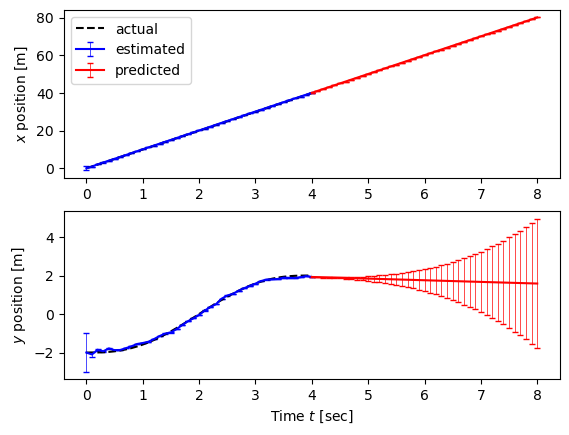

In [7]:
# Compute the inputs to the estimator
Y = np.vstack([xd[0:2] + W_lon, xd[0:2] + W_lat])
U = np.vstack([Y, ud])      # add input to the Kalman filter
# U = np.vstack([Y, ud * 0])  # with no input information
X0 = np.hstack([xd[:, 0], P0.reshape(-1)])

# Run the estimator on the trajectory
estim_resp = ct.input_output_response(estim, timepts, U, X0)

# Run a prediction to see what happens next
timepts_predict = np.arange(timepts[-1], timepts[-1] + 4 + Ts, Ts)
U_predict = np.outer(U[:, -1], np.ones_like(timepts_predict))
predict_resp = ct.input_output_response(
    estim, timepts_predict, U_predict, estim_resp.states[:, -1],
    params={'correct': False})

# Plot the estimated trajectory versus the actual trajectory
plt.subplot(2, 1, 1)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[0], 
    estim_resp.states[estim.find_state('P[0,0]')], 
    fmt='b-', **ebarstyle, label="estimated")
plt.errorbar(
    predict_resp.time, predict_resp.outputs[0], 
    predict_resp.states[estim.find_state('P[0,0]')],
    fmt='r-', **ebarstyle, label="predicted")
plt.plot(timepts, xd[0], 'k--', label="actual")
plt.ylabel("$x$ position [m]")
plt.legend()

plt.subplot(2, 1, 2)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[1], 
    estim_resp.states[estim.find_state('P[1,1]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[1], 
    predict_resp.states[estim.find_state('P[1,1]')], fmt='r-', **ebarstyle)
# lims = plt.axis(); plt.axis([lims[0], lims[1], -5, 5])
plt.plot(timepts, xd[1], 'k--');
plt.ylabel("$y$ position [m]")
plt.xlabel("Time $t$ [sec]");

More insight can be obtained by focusing on the errors in prediction:

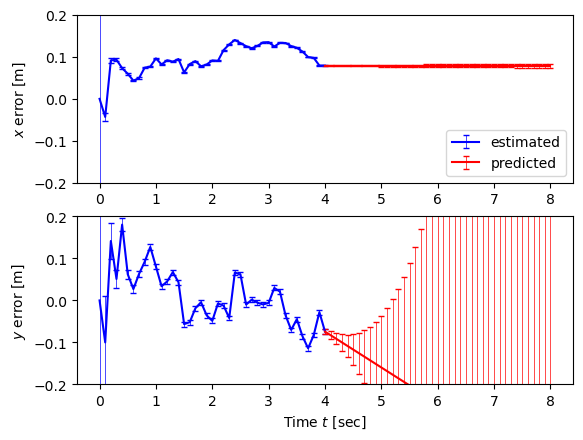

In [8]:
# Plot the estimated errors
plt.subplot(2, 1, 1)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[0] - xd[0], 
    estim_resp.states[estim.find_state('P[0,0]')],
    fmt='b-', **ebarstyle, label="estimated")
plt.errorbar(
    predict_resp.time, predict_resp.outputs[0] - (xd[0] + xd[0, -1]), 
    predict_resp.states[estim.find_state('P[0,0]')],
    fmt='r-', **ebarstyle, label="predicted")
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])
# lims = plt.axis(); plt.axis([lims[0], lims[1], -2, 0.2])
plt.ylabel("$x$ error [m]")
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.errorbar(
    estim_resp.time, estim_resp.outputs[1] - xd[1], 
    estim_resp.states[estim.find_state('P[1,1]')], fmt='b-', **ebarstyle)
plt.errorbar(
    predict_resp.time, predict_resp.outputs[1] - xd[1, -1], 
    predict_resp.states[estim.find_state('P[1,1]')], fmt='r-', **ebarstyle)
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])
plt.ylabel("$y$ error [m]")
plt.xlabel("Time $t$ [sec]");

### Things to try

To gain a bit more insight into sensor fusion, you can try the following:

* Remove the input (and update P0)
* Change the sampling rate

### Predictor-corrector form

Instead of using `create_estimator_iosystem`, we can also compute out the estimate in a more manual fashion, done here using the predictor-corrector form:

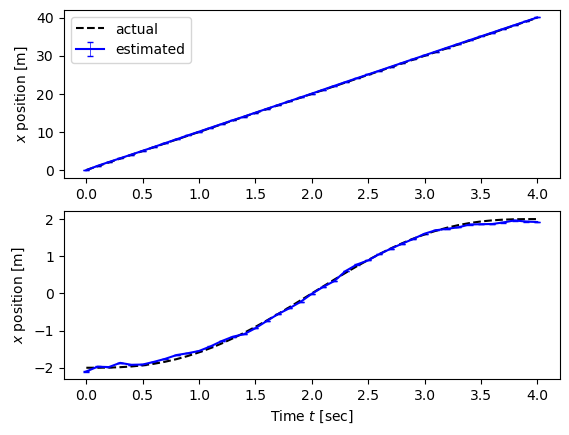

In [9]:
# System matrices
A, B, F = veh_lin_dt.A, veh_lin_dt.B, veh_lin_dt.B

# Create an array to store the results
xhat = np.zeros((veh_lin_dt.nstates, timepts.size))
P = np.zeros((veh_lin_dt.nstates, veh_lin_dt.nstates, timepts.size))

# Update the estimates at each time
for i, t in enumerate(timepts):
    # Prediction step
    if i == 0:
        # Use the initial condition
        xkkm1 = xd[:, 0]
        Pkkm1 = P0
    else:
        xkkm1 = A @ xkk + B @ ud[:, i-1]
        Pkkm1 = A @ Pkk @ A.T + F @ Rv @ F.T
    
    # Correction step
    L = Pkkm1 @ C.T @ np.linalg.inv(Rw + C @ Pkkm1 @ C.T)
    xkk = xkkm1 - L @ (C @ xkkm1 - Y[:, i])
    Pkk = Pkkm1 - L @ C @ Pkkm1

    # Save the state estimate and covariance for later plotting
    xhat[:, i], P[:, :, i] = xkk, Pkk
    # xhat[:, i], P[:, :, i] = xkkm1, Pkkm1  # For comparison to Kalman form
    
plt.subplot(2, 1, 1)
plt.errorbar(timepts, xhat[0], P[0, 0], fmt='b-', **ebarstyle, label="estimated")
plt.plot(timepts, xd[0], 'k--', label="actual")
plt.ylabel("$x$ position [m]")
plt.legend()

plt.subplot(2, 1, 2)
plt.errorbar(timepts, xhat[1], P[1, 1], fmt='b-', **ebarstyle)
plt.plot(timepts, xd[1], 'k--')
plt.ylabel("$x$ position [m]")
plt.xlabel("Time $t$ [sec]");

We can compare the results of the predictor-corrector form to the Kalman filter form used at the top of the notebook:

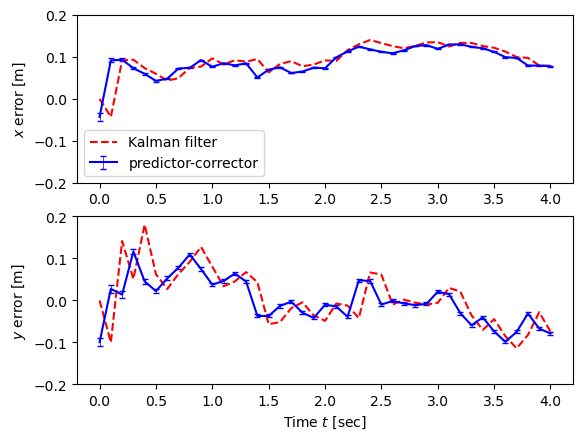

In [10]:
# Plot the estimated errors (and compare to Kalman form)
plt.subplot(2, 1, 1)
plt.errorbar(timepts, xhat[0] - xd[0], P[0, 0], fmt='b-', **ebarstyle, label="predictor-corrector")
plt.plot(estim_resp.time, estim_resp.outputs[0] - xd[0], 'r--', label="Kalman filter")
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])
plt.ylabel("$x$ error [m]")
plt.legend()

plt.subplot(2, 1, 2)
plt.errorbar(timepts, xhat[1] - xd[1], P[1, 1], fmt='b-', **ebarstyle)
plt.plot(estim_resp.time, estim_resp.outputs[1] - xd[1], 'r--')
lims = plt.axis(); plt.axis([lims[0], lims[1], -0.2, 0.2])
plt.ylabel("$y$ error [m]")
plt.xlabel("Time $t$ [sec]");

Note that the estimates are not the same!  It turns out that to get the correspondence of the two formulations, we need to define $\hat{x}_\text{KF}(k) = \hat{x}_\text{PC}(k|k-1)$ (see commented out code above).